In [5]:
!wget https://dataworks.indianapolis.iu.edu/bitstream/handle/11243/41/data.zip
!unzip data.zip
!rm data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/INSECTS_Images_2021/Amaxia alejandraloriae/08-SRNP-108433-DHJ632497+1364926612.jpg  
  inflating: data/INSECTS_Images_2021/Amaxia alejandraloriae/08-SRNP-108434-DHJ632498+1364926612.jpg  
  inflating: data/INSECTS_Images_2021/Amaxia alejandraloriae/08-SRNP-108435-DHJ632499+1364926612.jpg  
  inflating: data/INSECTS_Images_2021/Amaxia alejandraloriae/08-SRNP-108436-DHJ632500+1364926612.jpg  
  inflating: data/INSECTS_Images_2021/Amaxia alejandraloriae/08-SRNP-108439-DHJ632503+1364926612.jpg  
  inflating: data/INSECTS_Images_2021/Amaxia alejandraloriae/09-SRNP-105547_DHJ638782+1247675448.jpg  
  inflating: data/INSECTS_Images_2021/Amaxia alejandraloriae/09-SRNP-107418_DHJ640653+1252590540.jpg  
  inflating: data/INSECTS_Images_2021/Amaxia alejandraloriae/09-SRNP-109696-DHJ642931+1364926912.jpg  
  inflating: data/INSECTS_Images_2021/Amaxia alejandraloriae/09-SRNP-109697-DHJ642932+1364926912.jpg  
  inflating: data/INSE

In [6]:
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset import

In [7]:
class ImageDNADataset(Dataset):
    def __init__(self, train=True):
        splits_mat = scipy.io.loadmat("data/INSECTS/splits.mat")
        train_loc = splits_mat["train_loc"]-1
        trainval_loc = splits_mat["trainval_loc"]-1
        test_seen_loc = splits_mat["test_seen_loc"]-1
        test_unseen_loc = splits_mat["test_unseen_loc"]-1
        val_seen_loc = splits_mat["val_seen_loc"]-1
        val_unseen_loc = splits_mat["val_unseen_loc"]-1

        assert len(trainval_loc[0] == 19420)
        assert len(test_seen_loc[0] == 4965)
        assert len(test_unseen_loc[0] == 8463)

        indeces = (
            trainval_loc
            if train
            else np.concatenate((test_seen_loc, test_unseen_loc), axis=1)
        )
        # indeces.shape is (1, |indeces|), so we extract the whole list using [0]
        indeces = indeces[0]

        data_mat = scipy.io.loadmat("data/INSECTS/data.mat")
        self.embeddings_img = torch.from_numpy(
            data_mat["embeddings_img"][indeces]
        ).float()
        self.embeddings_dna = torch.from_numpy(
            data_mat["embeddings_dna"][indeces]
        ).float()

        # Remap train labels in [0, 796]
        train_labels = data_mat["labels"][trainval_loc][0]
        train_labels_mapping = {label: i for i, label in enumerate(np.unique(train_labels))}
        train_labels_remapped = np.array([train_labels_mapping[label.item()] for label in train_labels])

        # Remap test labels in [797, 1039]
        test_unseen_labels = data_mat["labels"][test_unseen_loc][0]
        test_unseen_labels_mapping = {label: i + 797 for i, label in enumerate(np.unique(test_unseen_labels))}
        test_unseen_labels_remapped = np.array([test_unseen_labels_mapping[label.item()] for label in test_unseen_labels])

        assert np.intersect1d(train_labels, test_unseen_labels).size == 0

        # Union of the two mappings, allows to full remap all the labels
        labels_mapping = train_labels_mapping | test_unseen_labels_mapping
        assert len(labels_mapping) == 1040

        labels = data_mat["labels"][indeces]  # Consider only train/test labels
        remapped_labels = np.array([labels_mapping[label.item()] for label in labels])
        self.remapped_labels = torch.from_numpy(remapped_labels).long()
        self.labels = torch.from_numpy(labels).long()

        if train:
            assert len(torch.unique(self.remapped_labels)) == 797
        else:
            assert len(torch.unique(self.remapped_labels)) == 1013

        # data_mat['G'] returns a ndarray of type uint16, therefore we convert into int16 before invoking from_numpy
        self.G = torch.from_numpy(data_mat["G"].astype(np.int16)).long()
        self.genera = torch.empty(self.labels.shape).long()
        for i in range(indeces.size):
            self.genera[i][0] = self.G[self.labels[i][0] - 1][0] - 1041

        if train:
            assert len(self.genera) == 19420
        else:
            assert len(self.genera) == 13428

        if (not train):
            # Compute genera of unseen species
            unseen_species_genera = []
            for i in test_unseen_loc[0]:
                unseen_species_genera.append(data_mat["G"][data_mat["labels"][i][0] - 1][0] - 1041)

            self.unseen_species_genera = np.array(unseen_species_genera)
            assert len(np.unique(self.unseen_species_genera)) == 134

            # Compute unseen species
            seen_species = []
            for i in test_seen_loc[0]:
                seen_species.append(labels_mapping[data_mat["labels"][i].item()])
            self.seen_species = np.array(seen_species)
            assert len(np.unique(self.seen_species)) == 770

        self.species = data_mat["species"][indeces]
        self.ids = data_mat["ids"][indeces]

    def __len__(self):
        return len(self.embeddings_dna)

    def __getitem__(self, idx):
        embedding_img = self.embeddings_img[idx]
        embedding_dna = self.embeddings_dna[idx]
        embedding = torch.cat(
            (self.embeddings_img[idx], self.embeddings_dna[idx])
        ).view(1, 1, -1)
        label = self.remapped_labels[idx].item()
        genera = self.genera[idx].item()

        return embedding_img.view(1, -1), embedding_dna.view(1, -1), label, genera

# Model definition

In [8]:
class CrossNet(nn.Module):
    def __init__(self):
        super(CrossNet, self).__init__()
        # Pre-core network
        # Image embedding dimensionality reduction
        self.img_fc1 = nn.Linear(2048, 1024)
        self.img_fc2 = nn.Linear(1024, 500)

        # Separate processing pipelines
        self.img_resblock1 = ResidualBlock1d(1, 4)
        self.img_resblock2 = ResidualBlock1d(4, 4)

        self.dna_resblock1 = ResidualBlock1d(1, 4)
        self.dna_resblock2 = ResidualBlock1d(4, 4)

        self.resblock1 = ResidualBlock1d(4, 4)
        self.resblock2 = ResidualBlock1d(4, 4)
        self.resblock3 = ResidualBlock1d(4, 4)
        self.resblock4 = ResidualBlock1d(4, 4)

        # Fully connected layers for classification
        self.fc_species_1 = nn.Linear(4*2548, 2048)
        self.fc_species_2 = nn.Linear(2048, 797)

        self.fc_genera_1 = nn.Linear(4*2548, 2048)
        self.fc_genera_2 = nn.Linear(2048, 368)

        # Dropout layers for regularization
        self.conv_dropout = nn.Dropout(0.2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x_img, x_dna):
        # Reduce dimensionality of image embeddings
        #x_img = F.relu(self.img_fc1(x_img))
        #x_img = F.relu(self.img_fc2(x_img))

        x_img = self.img_resblock1(x_img)
        x_img = self.img_resblock2(x_img)

        x_dna = self.dna_resblock1(x_dna)
        x_dna = self.dna_resblock2(x_dna)

        x = torch.cat((x_img, x_dna), axis=2)

        # CrossNet core
        x = F.relu(self.resblock1(x))
        x = self.conv_dropout(F.relu(self.resblock2(x)))
        x = F.relu(self.resblock3(x))
        x = self.conv_dropout(F.relu(self.resblock4(x)))

        x = x.view(x.shape[0], 4*2548)
        #x = self.dropout(F.relu(self.fc1(x)))

        x_species = x.clone()
        x_genera = x.clone()

        # Dropout for regularization
        x_species = self.dropout(F.relu(self.fc_species_1(x_species)))
        x_species = self.fc_species_2(x_species)

        x_genera = self.dropout(F.relu(self.fc_genera_1(x_genera)))
        x_genera = self.fc_genera_2(x_genera)

        return x_species, x_genera

class ResidualBlock1d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock1d, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        return out

# Creating datasets and dataloaders

In [9]:
model = CrossNet()
model.to(device)
training_set = ImageDNADataset(train=True)
test_set = ImageDNADataset(train=False)

batch_size = 32
training_loader = torch.utils.data.DataLoader(
    training_set, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False
)

Print datasets statistics.

In [10]:
print(f"Training set has {len(training_set)} instances.")
print(f"Test set has {len(test_set)} instances.")

inputs_img, inputs_dna, labels, genera = next(iter(training_loader))
print(f"Training input batch: {inputs_img.shape}, {inputs_dna.shape}")
print(f"Training label batch: {labels.shape}")
print(f"Training genera batch: {genera.shape}")

Training set has 19420 instances.
Test set has 13428 instances.
Training input batch: torch.Size([32, 1, 2048]), torch.Size([32, 1, 500])
Training label batch: torch.Size([32])
Training genera batch: torch.Size([32])


# Training

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 5

Training starts with the predefined number of epochs.

In [12]:
for epoch in range(epochs):

    running_labels_loss = 0.0
    running_genera_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        inputs_img, inputs_dna, labels, genera = data
        inputs_img, inputs_dna, labels, genera = inputs_img.to(device), inputs_dna.to(device), labels.to(device), genera.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        labels_outputs, genera_outputs = model(inputs_img, inputs_dna)
        labels_loss = criterion(labels_outputs, labels)
        genera_loss = criterion(genera_outputs, genera)
        total_loss = labels_loss + genera_loss
        total_loss.backward()
        optimizer.step()

        # print statistics
        running_labels_loss += labels_loss.item()
        running_genera_loss += genera_loss.item()
        print_step = 500
        if i % print_step == print_step - 1:
            print(f"[{epoch + 1}, {i + 1:5d}] labels loss: {running_labels_loss / print_step:.3f}")
            print(f"[{epoch + 1}, {i + 1:5d}] genera loss: {running_genera_loss / print_step:.3f}")
            running_labels_loss = 0.0
            running_genera_loss = 0.0

print("Finished Training")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


[1,   500] labels loss: 1.852
[1,   500] genera loss: 1.174
[2,   500] labels loss: 0.032
[2,   500] genera loss: 0.020
[3,   500] labels loss: 0.008
[3,   500] genera loss: 0.007
[4,   500] labels loss: 0.005
[4,   500] genera loss: 0.004
[5,   500] labels loss: 0.003
[5,   500] genera loss: 0.002
Finished Training


# Testing

-------------------------------------------------------------------------------
threshold: 0.999
Test described species accuracy: 0.9556776932161755
Test undescribed species accuracy: 0.42225183696492913
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
threshold: 0.9990256410256411
Test described species accuracy: 0.9556776932161755
Test undescribed species accuracy: 0.42233534771835346
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
threshold: 0.999051282051282
Test described species accuracy: 0.9553530178915002
Test undescribed species accuracy: 0.4225747096177521
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
threshold: 0.9990769230769231
Test described

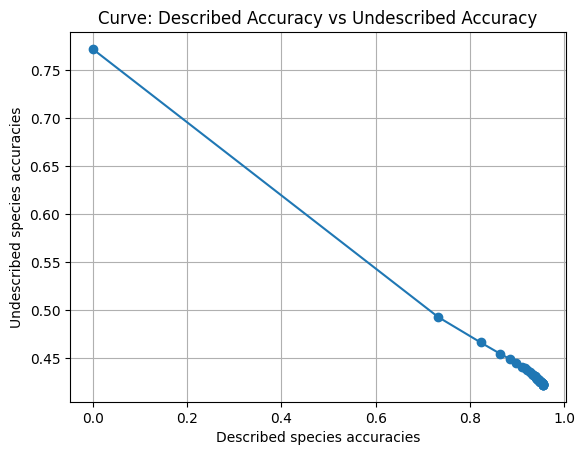

In [14]:
model.eval()

correct_genera = 0
total_genera = 0
correct_labels = 0
total_labels = 0

# Initialize lists to store accuracies
test_described_species_accuracies = []
test_undescribed_species_accuracies = []

# Define the range of thresholds to test
thresholds = np.linspace(0.999, 1, 40)

with torch.no_grad():
    for threshold in thresholds:
        correct_predictions_per_labels = defaultdict(int)
        total_samples_per_labels = defaultdict(int)
        correct_predictions_per_genera = defaultdict(int)
        total_samples_per_genera = defaultdict(int)

        correct_labels = 0
        total_labels = 0
        correct_genera = 0
        total_genera = 0

        for data in test_loader:
            inputs_img, inputs_dna, labels, genera = data
            inputs_img, inputs_dna, labels, genera = inputs_img.to(device), inputs_dna.to(device), labels.to(device), genera.to(device)

            labels_outputs, genera_outputs = model(inputs_img, inputs_dna)

            labels_outputs = nn.Softmax(dim=1)(labels_outputs)
            genera_outputs = nn.Softmax(dim=1)(genera_outputs)

            predicted_labels_values, predicted_labels = torch.topk(labels_outputs.data, k=2, dim=1)
            _, predicted_genera = torch.max(genera_outputs.data, 1)

            differences = predicted_labels_values[:, 0] - predicted_labels_values[:, 1]
            genera_mask = differences <= threshold
            labels_mask = ~genera_mask

            for idx in range(len(genera)):
                total_samples_per_genera[genera[idx].item()] += 1
                total_samples_per_labels[labels[idx].item()] += 1
                if genera_mask[idx]:
                    if predicted_genera[idx] == genera[idx]:
                        correct_predictions_per_genera[genera[idx].item()] += 1
                if labels_mask[idx]:
                    if predicted_labels[idx, 0] == labels[idx]:
                        correct_predictions_per_labels[labels[idx].item()] += 1

        accuracy_per_label = {label: (correct_predictions_per_labels[label] / total_samples_per_labels[label]) if total_samples_per_labels[label] > 0 else 0 for label in total_samples_per_labels}
        accuracy_per_genera = {genera: (correct_predictions_per_genera[genera] / total_samples_per_genera[genera]) if total_samples_per_genera[genera] > 0 else 0 for genera in total_samples_per_genera}

        test_described_species_accuracy = 0
        for label in np.unique(test_set.seen_species):
            test_described_species_accuracy += accuracy_per_label[label]

        test_undescribed_species_accuracy = 0
        for genera in np.unique(test_set.unseen_species_genera):
            test_undescribed_species_accuracy += accuracy_per_genera[genera]

        print("-------------------------------------------------------------------------------")
        print(f"threshold: {threshold}")
        print(f"Test described species accuracy: {test_described_species_accuracy / 770}")
        print(f"Test undescribed species accuracy: {test_undescribed_species_accuracy / 134}")
        print("-------------------------------------------------------------------------------")

        test_described_species_accuracies.append(test_described_species_accuracy / 770)
        test_undescribed_species_accuracies.append(test_undescribed_species_accuracy / 134)

# Plotting the curve
plt.plot(test_described_species_accuracies, test_undescribed_species_accuracies, marker='o')
plt.xlabel('Described species accuracies')
plt.ylabel('Undescribed species accuracies')
plt.title('Curve: Described Accuracy vs Undescribed Accuracy')
plt.grid(True)
plt.show()